In [5]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io
import scipy

import pyriemann
from pyriemann.classification import KNearestNeighbor
from pyriemann.classification import MDM
from pyriemann.classification import TSclassifier
from pyriemann.utils.distance import distance_euclid
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csgraph

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.covariance import LedoitWolf
import warnings
warnings.filterwarnings('ignore')


You can download the DATASET here : https://zenodo.org/record/4917218#.YoEcR-hBxPY

Just change data_path or eeg if you wanna work on the same dataset or another subject or subjects !

Saâd AZIZ ALAOUI

In [6]:
data_path='C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/P01'
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()*(10**6)


In [7]:
########################################
###Functions to manipulate the signal###
########################################

def reshape(signal): # Transforms the total signal by eraising the epoch dimension
    (a,b,c) = signal.shape
    Signal_total = np.zeros((b,a*c)) 
    for channel in range(b):
        Signal_total[channel,:] = signal[:,channel,:].flatten('C')
    return (Signal_total)


from scipy import signal as SIG
eeg_bands_info = {
  "delta": {
      "corner frq low" : 1,
      "corner frq high" : 4,
      "delta frq low" :0.75,
      "delta frq high" :1.75,
  },
  "theta": {
      "corner frq low" : 4,
      "corner frq high" : 8,
      "delta frq low" : 1.5,
      "delta frq high" : 2,
  },
  "alpha": {
      "corner frq low" : 8,
      "corner frq high" : 13,
      "delta frq low" : 2,
      "delta frq high" : 4,
      },
  "beta": {
      "corner frq low" : 13,
      "corner frq high" : 30,
      "delta frq low" : 4,
      "delta frq high" : 5,
      },
 "lower gamma": {
      "corner frq low" : 30,
      "corner frq high" : 80,
      "delta frq low" : 5,
      "delta frq high" : 7,
      },
  "upper gamma": {
      "corner frq low" : 80,
      "corner frq high" : 110,
      "delta frq low" : 7,
      "delta frq high" : 10,
      }
}
ripple_pband = 1
ripple_sband = 20
for k in eeg_bands_info.keys():
    eeg_bands_info[k]["Passband"]= [eeg_bands_info[k]["corner frq low"]+ eeg_bands_info[k]["delta frq low"]/2 ,eeg_bands_info[k]["corner frq high"]- eeg_bands_info[k]["delta frq high"]/2]
    eeg_bands_info[k]["Stopband"]= [eeg_bands_info[k]["corner frq low"]- eeg_bands_info[k]["delta frq low"]/2 ,eeg_bands_info[k]["corner frq high"]+ eeg_bands_info[k]["delta frq high"]/2]
    eeg_bands_info[k]["F_order"], eeg_bands_info[k]["Wn"] = SIG.cheb2ord(eeg_bands_info[k]['Passband'], eeg_bands_info[k]['Stopband'], ripple_pband, ripple_sband, fs=250)


def signal_freq_filtre(signal,freqs,fenetre): # Filters signals according to known EEG frequency bands
    F_order, Wn = SIG.cheb2ord(eeg_bands_info[freqs]['Passband'], eeg_bands_info[freqs]['Stopband'], ripple_pband, ripple_sband, fs=250)
    b, a = SIG.cheby2(eeg_bands_info[freqs]['F_order'],25, eeg_bands_info[freqs]['Wn'], btype = 'bandpass',analog =False, output ='ba', fs=250)
    eeg_signal_filtered = SIG.filtfilt(b,a,signal)
    
    return(eeg_signal_filtered)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


def signalCourt(signal,ind, size): # Return a signal window of size "size"
    return signal[:,ind:ind+size]


def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): 
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): 
    return abs(x)

In [8]:
####################################
####Matrix calculation functions####
####################################

def correlation_threshold(signal,fenetre, indice,k=10**(-10)): # Output : the binary matrix by signal correlation
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
    (a,b)=corr.shape
    threshold=np.zeros((a,b))

    return(corr)  

def correlation(signal):
    return(np.corrcoef(signal))

def covariance(signal):
    cov = LedoitWolf().fit(signal.T)
    return(cov.covariance_)


def covariance_threshold(signal,fenetre, indice,k=10**(-10)):# Output : the binary matrix by covariance of the signals
    cov= np.cov(signal[:,indice:indice+fenetre])
    (a,b)=cov.shape
    return(cov)

def matPLV(signal, fenetre, indice, freq): # Output : the phase matrix locking values
    A=np.zeros((61,61))
    signalFiltre=signal_freq_filtre(signal,freq,fenetre)
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),indice,fenetre)[i]))
            ph2=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),indice,fenetre)[j]))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq): # Output : Phase lag index matrix 
    
    B=np.zeros((61,61))
    signalFiltre=signal_freq_filtre(signal,freq,fenetre)
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),indice,fenetre)[i]))
            ph2=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),indice,fenetre)[j]))
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

def matInfoMut(signal, indice, fenetre,bins):# Output : Mutual information matrix 
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            

            X_norm=signalCourt(signal,indice,fenetre)[i]
            Y_norm=signalCourt(signal,indice,fenetre)[j]
            c_xy = np.histogram2d(X_norm, Y_norm, bins)[0]
            mi= mutual_info_score(None, None, contingency=c_xy)
            A[i,j]=mi
            
    return (A)

alphaTable=np.array([[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
                    [0,0,2,3,5,8,10,13,17,21,25,29,34,40,46,52,58,65,73,81,89,98,107,116,126,137]])

def monoExp(x, m, t, b, c):
    return m * np.exp(t * x+c) + b

p0 = (1, 1, 1, 1) # valeurs initiales pour l'optimisation sequentielle
params, cv = scipy.optimize.curve_fit(monoExp, alphaTable[0][:], alphaTable[1][:], p0)
m, t, b, c = params
xs2 = np.arange(50)
ys2 = monoExp(xs2, m, t, b, c)


def matwPLWT(signal, ind, fenetre, freq): # Output : PLWT matrix

    A=np.zeros((61,61))

    for i in range (61):
        for j in range (61):
            if i !=j:             
                theta1=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),ind,fenetre)[i]))
                theta2=phase_analytique(analytic_signal(signalCourt(signal_freq_filtre(signal,freq,fenetre),ind,fenetre)[j]))
                
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                PLWT=abs((tpos-tneg)/(tpos+tneg))
                A[i,j]=PLWT
    return (A)

def matPLWT(signal, ind, fenetre, freq,alpha=.05): #output: Binary PLWT matrix (Gaussian approx for n>30)

    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            if i !=j:
                theta1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[i],freq,fenetre)))
                theta2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,ind,fenetre)[j],freq,fenetre)))
                dtheta=theta1-theta2
                sintheta=np.sin(dtheta)
                abssintheta=(abs(np.sin(dtheta)))
                sort=np.sort(abssintheta)
                tpos=0
                tneg=0
                for k in range (len(theta1)):
                    if sintheta[k]>0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tpos=tpos+K
                    elif sintheta[k]<0:
                        K=np.where(abssintheta == abs(sintheta[k]))[0]
                        tneg=tneg+K
                T=min(tpos, tneg)
                n=len(theta1)
                if (n<=30) :
                    Tc=alphaTable[1][n-5]
                    if T<Tc:
                        PLWT=1
                    else:
                        PLWT=0
                else:
                    sig=(n*(n+1)*(2*n+1)/24)
                    mu=n*(n+1)/4
                    Z=(T-mu)/(sig)
                    Zc=1.645 
                    if Z<Zc:
                        PLWT=1
                    else:
                        PLWT=0
                A[i,j]=PLWT
    return (A)

In [9]:
##########################################
#####Function to manipulate matrices######
##########################################

def emptyDiago(A): # Matrix with empty diago 
    for i in range (A.shape[0]):
        A[i,i]=0
    return (A)

def degreeMat(A): # Output : Degree matrix 
    a,b=A.shape
    B=np.zeros((a,b))
    for i in range (a):
        s=0
        for j in range (b):
            s=s+A[i,j]
        B[i,i]=s
    return (B)

def laplacien(A): # Laplacian for Matrix
    return (degreeMat(emptyDiago(A))-emptyDiago(A))

def threshold(mat,k): # Binary matrix if the threshold is exceeded
    return np.where(mat>k, 1,0)

def vectorise(mat): # Extracts the upper triangular part of the matrix as a one-dimensional vector
    return mat[np.triu_indices(mat.shape[0],k=1)]

def shuffle_in_unison(a, b): # Mixes a and b in the same way
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 825 samples (3.300 sec)

(149, 61, 500)
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00

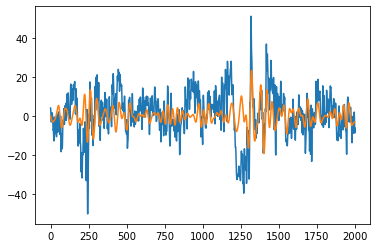

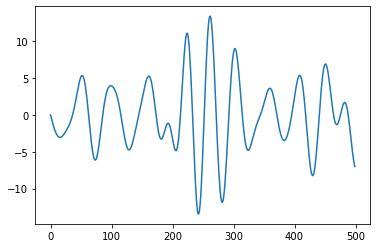

In [10]:
data_path='C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/P01'
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
tmp = eeg.get_data()*(10**6)

# Pre-filtering the signals

data_filtre=mne.filter.filter_data(eeg,sfreq=250, l_freq=1, h_freq=4 )
print(tmp.shape)


data_filtre2=mne.filter.filter_data(reshape(tmp),sfreq=250, l_freq=4, h_freq=8)
plt.plot(reshape(tmp)[0,0:2000])
plt.plot(data_filtre2[0,0:2000])
p=100


# Store in a file a tensor 61*Nsamples*N_bands
# Make a short list that clearly indicates which index corresponds to which band

np.save('C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/P01/test', data_filtre2)

loading=np.load('C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/P01/test.npy')
print(loading.shape)

plt.figure(3)

plt.plot(loading[0,0:500])



In [13]:
def save_filtre():
    path='C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/'
    sujet_vect=['1'] # à augmenter
    session_vect=['1','2']
    diff_vect=['easy','med','diff']
    save_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/filtre/'
    bandes=[[1,4],[4,8],[8,13],[13,30],[30,80],[80,110]]
    bandes_correspondantes=['delta','theta','alpha','beta','lower gamma','upper gamma']
    for sujets in sujet_vect:
        for session in session_vect:
            for diff in diff_vect:
                array=path+'P0'+sujets+'/S'+session+'/eeg/alldata_sbj0'+sujets+'_sess'+session+'_MATB'+diff+'.set'
                eeg=mne.io.read_epochs_eeglab(array, verbose=False)
                tmp = eeg.get_data()*(10**6)
                tensor=np.zeros((61,74500,len(bandes)))
                for i in range (len(bandes)):
                    data_filtre=mne.filter.filter_data(reshape(tmp),sfreq=250, l_freq=bandes[i][0], h_freq=bandes[i][1])
                    tensor[:,:,i]=data_filtre
                np.save(save_path+diff+'_sess_'+session+'_sujet_'+sujets,tensor)
                    
save_filtre()


Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter l

FileNotFoundError: [Errno 2] No such file or directory: '/Users/charlesgirard/Desktop/Centrale/ei2/Projet/filtre/easy_sess_1_sujet_1.npy'

In [18]:
# This function creates a vector of size ((n*N)*K) where n*N is the number of instances where a statistic is calculated
# Across the 6 sessions of subject 1 (n:instants/session (= instants/file) and N: number of sessions)
# K is the size of the vector that comes from the 61x61 matrix --> K=(60*61)/2
# Output: Y which is the vector that contains 0,1 or 2 depending on the mental load difficulty
# and X which is the vector ((n*N)*K) of d

# This function was used for the Euclidean classification

Translated with www.DeepL.com/Translator (free version)
def makeTrain(N,n,taillef,frequence,mesure,bins=5,thresh=10**(-10) ): #n is the number of moments per session, N is the number of sessions
    data_path='C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/'
    numberVect=np.array(['1','1','1','2','2','2']) # The patient's session number 01 (in total 6 files as 2 sessions of 3 measurements are labelled)
    M=numberVect.shape[0]
    diffVect=np.array(['diff', 'easy', 'med', 'diff','easy', 'med']) # Difficulties associated with .set files
    y=np.zeros((N*n,1))
    x=np.zeros((N*n,1830))
    
    for k in range(M):
        array='/Train/alldata_sbj01_sess'+numberVect[k]+'_MATB'+diffVect[k]+'.set'# Points to a folder with all sessions of the same subject together
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()
        signalTotal2=reshape(tmp)     
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n) # Evenly distributes the index over the 5 minute measurement period
            if mesure== 'wPLWT':
                mat=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                mat=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                mat=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
                mat=correlation_threshold(signalTotal2,taillef, indice)
            elif mesure=="covariance":
                mat=covariance_threshold(signalTotal2,taillef, indice,thresh)
                
            x[n*k+i,:]=vectorise(mat).T # Filled per row the matrix x
            

            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2              ## Associates the difficulty with the vector y
                
    return (x,y)



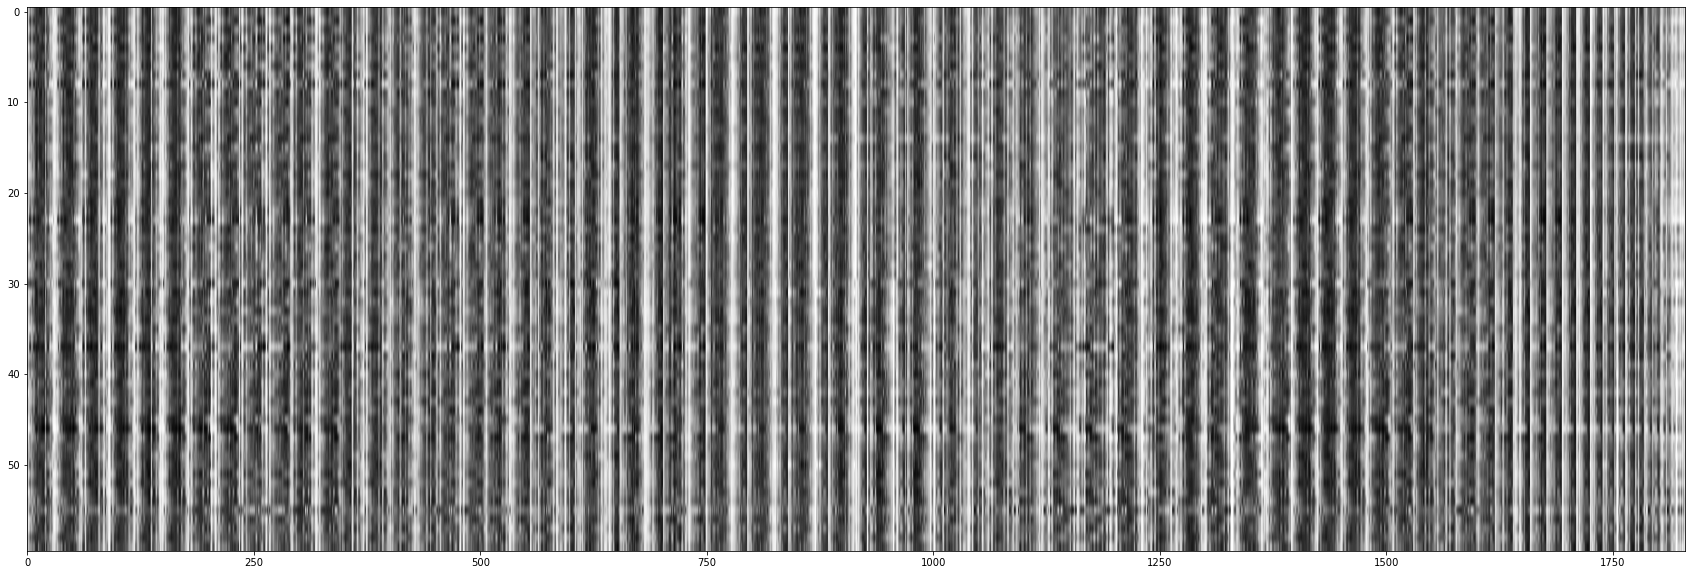

In [19]:
N1=6
n1=10

(X1,Y1)=makeTrain(N1,n1,500,'alpha','correlation',5,0.2*10**(-10))
plt.figure(figsize=(100,10))
plt.imshow(X1,aspect=10,cmap='gray')




In [20]:
(Xnew,Ynew)=shuffle_in_unison(X1,Y1)
print("xnew" ,Xnew.shape)
print("ynew" ,Ynew.shape)

# We mix the data 

xnew (60, 1830)
ynew (60, 1)


In [21]:
index=int(0.8*N1*n1)
print(index)

Xtrain=Xnew[0:index]
Xtest=Xnew[index:N1*n1]
Ytrain=Ynew[0:index]
Ytest=Ynew[index:N1*n1]   # Train and test data are separated

Ytrain=Ytrain.ravel()
Ytest=Ytest.ravel()

neigh = KNeighborsClassifier(n_neighbors=2) # KNN Classification 
neigh.fit(Xtrain, Ytrain)

sco1=neigh.score(Xtest, Ytest)
print(sco1, "sco1")


clf = svm.SVC(kernel="rbf", gamma=0.01) # SVM classification works best for kernel rbf and gamma=0.01, for covariance and 300 instants
clf.fit(Xtrain, Ytrain)
sco2=clf.score(Xtest,Ytest)
print(sco2, "sco2")


48
0.5833333333333334 sco1
0.5833333333333334 sco2


In [22]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=10000).fit(Xtrain, Ytrain) # classification réseau de neurone
sco3=clf.score(Xtest, Ytest)
print(sco3)


0.5833333333333334


In [25]:
## PyRiemman and matrix classification

## Create a matrix database

# Same as makeTrain, but returns a vector of SPD matrices instead of a vector
# Return the train database for a session
def makeTrainMat(n,taillef,frequence,mesure,sessNumber,pnumber,laplacian_type='original',bins=5,thresh=10**(-10)): #n est le nombre d'instants par session (par séance de 5 mins), M est le nombre de difficultés (3)
    data_path='C:/Users/saada/OneDrive/Bureau/Etudes/PRTSI1/BDD/P0'+str(pnumber)+'/S'+str(sessNumber)+'/eeg'
    diffVect=np.array(['diff', 'easy', 'med'])
    M=diffVect.shape[0]
    y=np.zeros((M*n,1))
    x=np.zeros((M*n,61,61))
    
    for k in range (M):
        if pnumber<10:
            
            array='/alldata_sbj0'+str(pnumber)+'_sess'+str(sessNumber)+'_MATB'+diffVect[k]+'.set'#pointe vers un dossier avec l'information de la session "sessNumber"
        if pnumber>=10:
            array='/alldata_sbj'+str(pnumber)+'_sess'+str(sessNumber)+'_MATB'+diffVect[k]+'.set'
        eeg=mne.io.read_epochs_eeglab(data_path+array, verbose=False)
        tmp = eeg.get_data()*(10**6)
        signalTotal2=reshape(tmp) 
        for i in range (n):
            indice=int((signalTotal2.shape[1]-taillef)*i/n)
            if mesure== 'wPLWT':
                Weight_mtx=matwPLWT(signalTotal2, indice, taillef, frequence)
            elif mesure== 'infoMut':
                Weight_mtx=matInfoMut(signalTotal2, indice, taillef,bins)
            elif mesure== "PLV":
                Weight_mtx=matPLV(signalTotal2, taillef, indice, frequence)
            elif mesure== "PLI":
                Weight_mtx=matPLI(signalTotal2, taillef, indice, frequence)
            elif mesure=="correlation":
                Weight_mtx=correlation(signalCourt(signal_freq_filtre(signalTotal2,frequence, taillef),indice, taillef))
            elif mesure=="covariance":
                Weight_mtx=covariance(signalCourt(signal_freq_filtre(signalTotal2,frequence, taillef),indice, taillef))
            elif mesure=="PLWT":
                Weight_mtx=matPLWT(signalTotal2, indice, taillef, frequence,alpha=.05)
            
            lmbda = 0.01    
            if laplacian_type == 'original':
                Laplacian = laplacien(Weight_mtx)+lmbda*np.eye(Weight_mtx.shape[0])
                x[n*k+i,:]= Laplacian
            elif laplacian_type == 'norm':
                np.fill_diagonal(Weight_mtx, 0.0)
                # degree diagonal matrix
                D = np.diag(np.sum(Weight_mtx,axis=1))
                # identity (eye)
                I = np.identity(Weight_mtx.shape[0])
                # D^{-1/2} matrix
                D_inv_sqrt = np.linalg.inv(np.sqrt(D))
                L = I - np.dot(D_inv_sqrt, Weight_mtx).dot(D_inv_sqrt)
                Laplacian = L+lmbda*np.eye(Weight_mtx.shape[0])  
                x[n*k+i]=Laplacian
            elif laplacian_type=='skip':
                x[n*k+i]=Weight_mtx
#             print(is_pos_def(Laplacian)) 
#             x[n*k+i]=Weight_mtx
            if diffVect[k]== 'easy':
                y[n*k+i]=0
            elif diffVect[k]== 'med':
                y[n*k+i]=1
            elif diffVect[k]== 'diff':
                y[n*k+i]=2
    return (x,y)


In [27]:
(XTrain,YTrain)=makeTrainMat(10,500,'alpha','covariance',1,1,bins=5)


-3.4505765477598676


KNearestNeighbor()

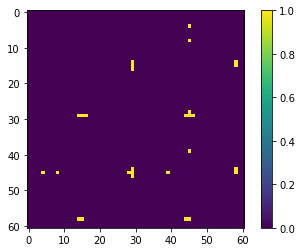

In [28]:
## Create train and test
(XTrain,YTrain)=makeTrainMat(30,500,'beta','covariance',1,1)
(XTest,YTest)=makeTrainMat(1,500,'beta','covariance',2,1)
print(XTrain[0,0,1])
# plt.imshow(XTrain[1], 15)
plt.imshow(threshold(XTrain[1], 9))
plt.colorbar()

## Classifier

classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
classi.fit(XTrain,YTrain)
# classi.score(XTest,YTest)


In [30]:
np.mean(cross_val_score(classi, XTrain, YTrain))

nan

In [14]:
# Evaluate the cross assessment score on all subjects according to the sessions
# Training and validation on the same topics

patients=[1,2,3,4,5,6] # Only 6 patients due to time constraints
sessions=[1,2]
Npatients=len(patients)
Nsessions=len(sessions)
resultCrossValTrainTrain=np.zeros((Npatients,Nsessions))
resultCrossValTrainTest=np.zeros((Npatients,Nsessions))
for patient in patients:
    for session in sessions:
        (XTrain,YTrain)=makeTrainMat(30,500,'beta','covariance',session,patient)
        
        (XTest,YTest)=makeTrainMat(10,500,'beta','covariance',session,patient)
        
        classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
        
        classi.fit(XTrain,YTrain)
        resultCrossValTrainTrain[patient-1,session-1]=np.mean(cross_val_score(classi, XTrain, YTrain))
        resultCrossValTrainTest[patient-1,session-1]=np.mean(cross_val_score(classi, XTest, YTest))


plt.imshow(resultCrossValTrainTrain)
plt.title('Validation = Train')
plt.imshow(resultCrossValTrainTest)
plt.title('Validation != Train')
plt.colorbar()




KeyboardInterrupt: 

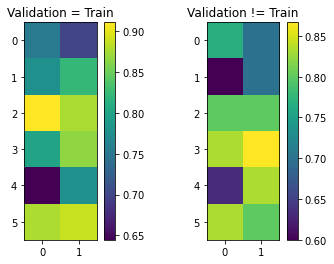

In [23]:
plt.subplot(1,2,1)
plt.imshow(resultCrossValTrainTrain)
plt.title('Validation = Train')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(resultCrossValTrainTest)
plt.title('Validation != Train')
plt.colorbar()

In [11]:
(XTrain,YTrain)=makeTrainMat(10,500,'beta','covariance',1,1) 
a = pyriemann.channelselection.ElectrodeSelection(nelec=18, metric='riemann', n_jobs=1)
A = a.fit(X=XTrain, y=YTrain[:,0])


In [15]:
# Let's evaluate the score of cross evaluation on all subjects according to the classifier
# Training and validation on the same subject

patients=[1,2,3,4,5,6,7,8,9]
sessions=[1,2]
Npatients=len(patients)
Nsessions=len(sessions)
M=4
resultCrossValTrainTrain=np.zeros((Npatients,M,5))


for patient in patients:
    nFenetre=50
    (XTrain,YTrain)=makeTrainMat(nFenetre,500,'beta','covariance',1,patient,laplacian_type='original') 
    
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain[patient-1,0]=cross_val_score(classi, XTrain, YTrain)
    
    classi=pyriemann.classification.MDM( metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain[:,0])
    resultCrossValTrainTrain[patient-1,1]=cross_val_score(classi, XTrain, YTrain[:,0])
    
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='euclid', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain[patient-1,2]=cross_val_score(classi, XTrain, YTrain)
    
    classi=pyriemann.classification.TSclassifier()
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain[patient-1,3]=cross_val_score(classi, XTrain, YTrain)
    


LinAlgError: The leading minor of order 1 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

[0.74       0.81333333 0.61333333 0.86       0.77333333 0.77333333
 0.61333333 0.95333333 0.91333333 0.86       0.56666667 0.95333333
 0.83333333 0.82       0.68       0.9        0.74666667 0.63333333
 0.53333333 0.89333333 0.90666667 0.85333333 0.72666667 0.95333333
 0.90666667 0.91333333 0.75333333 0.94666667 0.8        0.8
 0.74       0.84666667 0.84       0.79333333 0.59333333 0.92      ]


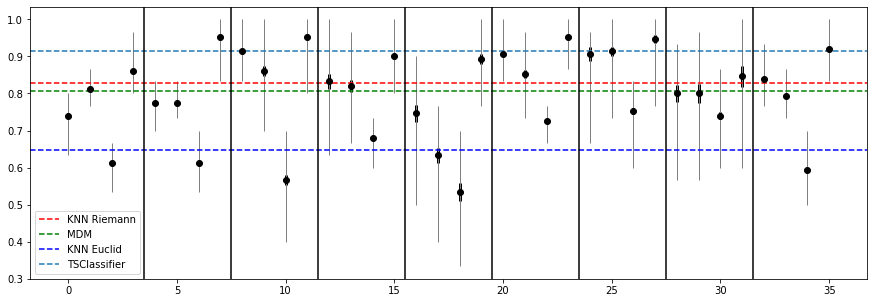

In [137]:
mean=np.mean(resultCrossValTrainTrain,axis=2)
means=np.matrix.flatten(mean)
a,b,c=resultCrossValTrainTrain.shape
cov=np.zeros((a,b))
minValue=np.zeros((a,b))
maxValue=np.zeros((a,b))
for i in range (a):
    for j in range (b):
        cov[i,j]=np.cov(resultCrossValTrainTrain[i,j,:])
        minValue[i,j]=np.ndarray.min(resultCrossValTrainTrain[i,j,:])
        maxValue[i,j]=np.ndarray.max(resultCrossValTrainTrain[i,j,:])
std=np.matrix.flatten(cov)
mins=np.matrix.flatten(minValue)
maxs=np.matrix.flatten(maxValue)

# Vectors of: mean, standard deviation, min and max are calculated for the following graph

categories = np.zeros(means.shape)
for i in range (len(categories))
    categories[i]=int(i%4)
categories=categories.astype(int)
colormap = np.array(['r', 'g', 'b'])

plt.figure(figsize=(15,5))
plt.errorbar(np.arange(a*b), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(a*b), means, [means - mins, maxs - means],fmt='.k', ecolor='gray', lw=1)
plt.axhline(y=np.mean(mean[:,0]), color='r', linestyle='--',label='KNN Riemann')
plt.axhline(y=np.mean(mean[:,1]), color='g', linestyle='--',label="MDM")
plt.axhline(y=np.mean(mean[:,2]), color='b', linestyle='--',label='KNN Euclid')
plt.axhline(y=np.mean(mean[:,3]), linestyle='--',label='TSClassifier')
plt.legend(loc="bottom left")


for i in range (a-1):
    
    plt.axvline(x=4*i+3.5, color='k',linestyle='-')
    


# plt.yaxis('off')


In [ ]:
# The horizontal lines correspond to the means of each classifier,
# the grey bands are the min/max, the black bands the standard deviation
# Each subject is delimited by a vertical black band
# For each subject, we have its cross-validation result for: KNN Riemannian, MDM, KNN Euclidean and TS (in this order)

In [23]:
# Evaluate the cross-assessment score on all subjects according to the measures
# Training and validation on the same subject
patients=[1,2,3,4,1,6,7,8,9]
# patients=[1]
sessions=[1,2]
Npatients=len(patients)
Nsessions=len(sessions)
M=3
resultCrossValTrainTrain2=np.zeros((Npatients,M,5))


for patient in patients:

    nFenetre=10

    (XTrain,YTrain)=makeTrainMat(nFenetre,500,'beta','covariance',1,patient,laplacian_type='skip')         
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain2[patient-1,0]=cross_val_score(classi, XTrain, YTrain)

    (XTrain,YTrain)=makeTrainMat(nFenetre,500,'beta','infoMut',1,patient,laplacian_type='original')         
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain2[patient-1,1]=cross_val_score(classi, XTrain, YTrain)
    (XTrain,YTrain)=makeTrainMat(nFenetre,500,'beta','correlation',1,patient,laplacian_type='skip')         
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain2[patient-1,2]=cross_val_score(classi, XTrain, YTrain)
    


1
cov
plv
corr
2
cov
plv
corr
3
cov
plv
corr
4
cov
plv
corr
1
cov
plv
corr
6
cov
plv
corr
7
cov
plv
corr
8
cov
plv
corr
9
cov
plv
corr


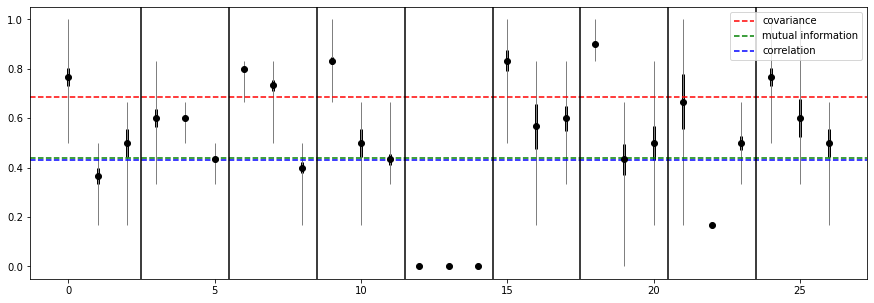

In [25]:
mean=np.mean(resultCrossValTrainTrain2,axis=2)
means=np.matrix.flatten(mean)
a,b,c=resultCrossValTrainTrain2.shape
cov=np.zeros((a,b))
minValue=np.zeros((a,b))
maxValue=np.zeros((a,b))
for i in range (a):
    for j in range (b):
        cov[i,j]=np.cov(resultCrossValTrainTrain2[i,j,:])
        minValue[i,j]=np.ndarray.min(resultCrossValTrainTrain2[i,j,:])
        maxValue[i,j]=np.ndarray.max(resultCrossValTrainTrain2[i,j,:])
std=np.matrix.flatten(cov)
mins=np.matrix.flatten(minValue)
maxs=np.matrix.flatten(maxValue)
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(a*b), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(a*b), means, [means - mins, maxs - means],fmt='.k', ecolor='gray', lw=1)
plt.axhline(y=np.mean(mean[:,0]), color='r', linestyle='--',label='covariance')
plt.axhline(y=np.mean(mean[:,1]), color='g', linestyle='--',label="mutual information")
plt.axhline(y=np.mean(mean[:,2]), color='b', linestyle='--',label="correlation")
for i in range (a-1):
    
    plt.axvline(x=3*i+2.5, color='k',linestyle='-')
plt.legend(loc="bottom left")

In [ ]:
# The horizontal lines are the means of each characteristic,
# the grey bands are the min/max, the black bands the standard deviation
# Each subject is delimited by a vertical black band
# For each subject we have the cross-validation result for covariance, mutual information, and correlation (in that order)
# Some feature calculations do not work/take too long to calculate

In [8]:
# Evaluate the score of cross evaluation on all subjects according to the size of the window
# Training and validation on the same topic

sessions=[1,2]
Nsessions=len(sessions)
fenetres=[100*i for i in range (1,50)]
Nfenetres=len(fenetres)
resultCrossValTrainTrain3=np.zeros((Nfenetres,5))


for i in range (Nfenetres):
    patient=1
    nFenetre=30
    
    (XTrain,YTrain)=makeTrainMat(nFenetre,fenetres[i],'beta','covariance',sessNumber=1,pnumber=patient,laplacian_type='skip')         
    classi=pyriemann.classification.KNearestNeighbor(n_neighbors=5, metric='riemann', n_jobs=1)
    classi.fit(XTrain,YTrain)
    resultCrossValTrainTrain3[i]=cross_val_score(classi, XTrain, YTrain)
    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


Text(0, 0.5, 'Cross Val Score')

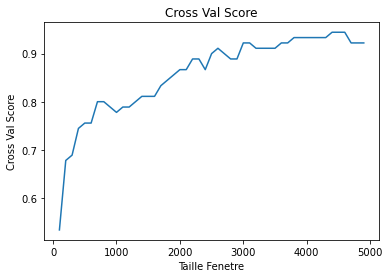

In [9]:
mean=np.mean(resultCrossValTrainTrain3,axis=1)
means=mean

a,b=resultCrossValTrainTrain3.shape
cov=np.zeros((a,1))
minValue=np.zeros((a,1))
maxValue=np.zeros((a,1))
for i in range (a):
    cov[i]=np.cov(resultCrossValTrainTrain3[i,:])
    minValue[i]=np.ndarray.min(resultCrossValTrainTrain3[i,:])
    maxValue[i]=np.ndarray.max(resultCrossValTrainTrain3[i,:])
    
std=cov.ravel()
mins=minValue.ravel()
maxs=maxValue.ravel()

plt.plot(fenetres, means)
plt.title('Cross Val Score')
plt.xlabel('Taille Fenetre')
plt.ylabel('Cross Val Score')
